/tmp/ipykernel_1418/2041356506.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.uint8(np.clip(a, 0, 255))


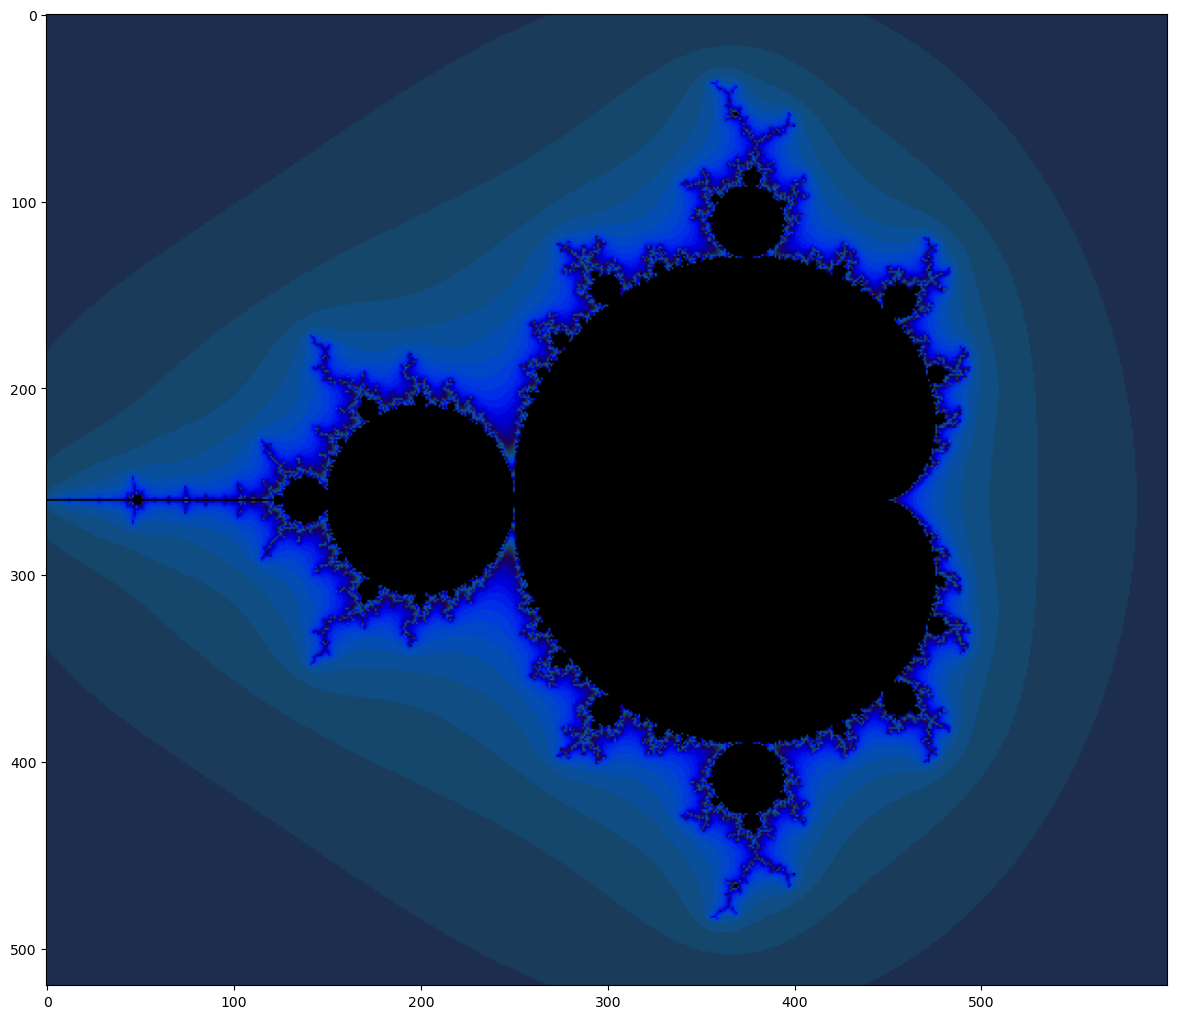

In [ ]:
# Task 2.1
import torch
import numpy as np

# --- Device configuration ---
# Check if CUDA is available, otherwise set device to CPU
# CUDA is NVIDIA's parallel computing platform that lets software use a GPU for computing
# This will allow the code to run on a GPU if available, which is much fast thern a CPU for image proccessing,
# simulations, and big matrix math since it can run thousands of small operations in parallel.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Grid ---
# Use NumPy to create a 2D array of complex numbers on [-2,2]x[-2,2]
# Creates a grid from -1.3 to 1.3, with a step size of 0.005
# X and Y are 2D arrays representing the grid coordinates
Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]

# --- load into PyTorch tensors ---
# Converts the NumPy arrays X and Y into PyTorch tensors 
# A tensor is a multi-dimensional array data structure
# Allows running operations on the GPU or CPU, making it better for image processing,
# simulations, and big matrix math since it can run thousands of small operations in parallel.
x = torch.Tensor(X)
y = torch.Tensor(Y)

# --- Convert to complex numbers ---
# Combines x as the real part and y as the imaginary part to make a tensor of complex numbers
z = torch.complex(x, y) #important!

# Makes a deep copy of the complex tensor z so you can modify zs in calculations without changing the original coordinates.
zs = z.clone() 

# Creates a new tensor filled with zeros, with the same shape and data type as z (in this case, complex).
ns = torch.zeros_like(z)

# --- Transfer to the device ---
# Moves the tensors x and y to the location specified by the device
# If device = "cpu" → keeps them in system memory (normal CPU processing).
# If device = "cuda" → moves them into the GPU’s memory so PyTorch can run operations on the GPU.
z = z.to(device)
zs = zs.to(device)
ns = ns.to(device)

# --- Compute the Mandelbrot Set ---
# Mandelbrot formula: z_{n+1} = z_n**2 + c   (c = initial point in complex plane)

# After the loop:
# ns -> 2D tensor showing how many iterations each point stayed bounded (|z| < 2).
#       Points inside the Mandelbrot set will have values near the max iteration count (200),
#       while points outside will have smaller values depending on escape speed.
# zs -> Final complex values after the last iteration (usually not needed for plotting).

for i in range(200):
  # Applies the Mandelbrot formula for every point in the grid 
  # z holds the original coordinates (the constant c) and zs holds the current iteration values
  zs_ = zs*zs + z

  # True if point is still bounded (|z| < 2), False if it diverged
  not_diverged = torch.abs(zs_) < 4.0

  # --- Counts how many iterations each point has stayed bounded ---
  # Each point in ns stores a counter for each point in the grid.
  # ns and not_diverged are the same shape as the grid.
  # Each element in ns lines up with the same element in not_diverged.
  # Adding them updates each ns[i, j] with not_diverged[i, j] (element-wise).
  ns += not_diverged

  # Set current z values to the newly computed ones for the next iteration
  zs = zs_


# --- Plot ---
import matplotlib.pyplot as plt

# Create a blank figure, 16 inches wide and 10 inches tall.
# In Matplotlib, a figure is the entire canvas that holds everything you draw — plots, titles, legends, axes, etc.
fig = plt.figure(figsize=(16,10))

def processFractal(a):
  """Display an array of iteration counts as a
  colorful picture of a fractal."""

  """Takes the numeric values in a, maps them into colors using sine and cosine patterns, 
  blacks out the maximum value region, and formats the result as a standard 8-bit RGB image."""
  
  # Convert 'a' into radians (6.28 ≈ 2π) and add an extra dimension for broadcasting.
  a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])

  # Creating a color image by making three separate 2D arrays — one for red, one for green, and one for blue — and then combining them into a single 3D array.
  #  - Red   = 10 + 20*cos(a_cyclic)
  #  - Green = 30 + 50*sin(a_cyclic)
  #  - Blue  = 155 - 80*cos(a_cyclic)
  # You get an array shaped (height, width, 3), where each pixel’s color is defined by its three numbers [R, G, B].
  img = np.concatenate([
    10+20*np.cos(a_cyclic),
    30+50*np.sin(a_cyclic),
    155-80*np.cos(a_cyclic)
  ], 2)

  # Set the pixels where 'a' is at its maximum value to black.
  img[a==a.max()] = 0

  # Replace 'a' with the new image array.
  a = img 

  # Clip values to the range [0, 255] and convert to unsigned 8-bit integers for image format.
  a = np.uint8(np.clip(a, 0, 255))

  # Return the final RGB image.
  return a

# Convert ns to NumPy, map iteration counts to RGB colors, and display as an image.
plt.imshow(processFractal(ns.cpu().numpy()))

plt.tight_layout(pad=0)
plt.show()

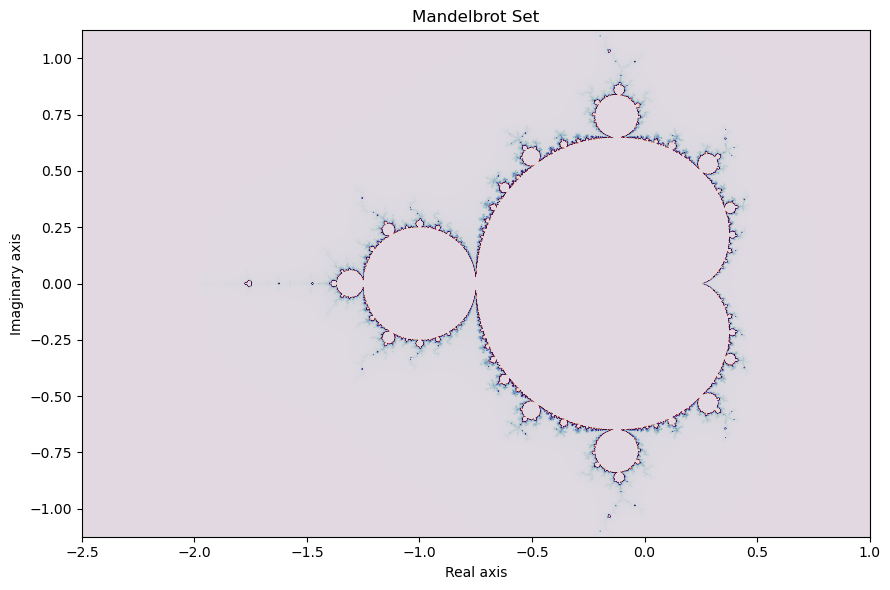

In [13]:
# Task 2.2
# AI Prompt: generate the mandelbrot set implemented in pytorch that runs on the GPU
import torch
import matplotlib.pyplot as plt

# --- Config ---
W, H = 1400, 900         # Image width and height in pixels
max_iter = 500           # Maximum iterations per pixel

# View window (controls zoom and position on the complex plane)
x_center, y_center = -0.75, 0.0  # Center point of the view in complex plane
zoom = 1.0                       # Zoom level (smaller = zoom in)
x_span = 3.5 * zoom               # Width of the view in complex plane units
y_span = x_span * (H / W)         # Height of the view adjusted for aspect ratio

# --- Device ----
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Build complex grid ---
# Create evenly spaced real values for x-axis and y-axis
x = torch.linspace(x_center - x_span/2, x_center + x_span/2, W, device=device)
y = torch.linspace(y_center - y_span/2, y_center + y_span/2, H, device=device)

# Create 2D coordinate grid from x and y (Y first due to 'ij' indexing)
Y, X = torch.meshgrid(y, x, indexing="ij")

# Combine into complex plane points: C = X + iY
C = X + 1j * Y

# Z will store iteration results, starts at zero for all points
Z = torch.zeros_like(C)

# Store escape iteration count for each pixel, default to max_iter
escape_iter = torch.full((H, W), max_iter, device=device, dtype=torch.float32)

# Boolean mask to track which points are still being iterated
mask = torch.ones((H, W), dtype=torch.bool, device=device)

# --- Iteration loop ---
for i in range(max_iter):
    # Apply Mandelbrot formula: Z = Z^2 + C (only for points still active in mask)
    Z[mask] = Z[mask]*Z[mask] + C[mask]
    
    # Determine which points have "escaped" (magnitude > 2, so |Z|^2 > 4)
    diverged = (Z.real*Z.real + Z.imag*Z.imag) > 4.0
    
    # Identify points that just diverged in this iteration
    newly_diverged = diverged & mask
    
    if newly_diverged.any():
        # Continuous (smooth) escape time calculation
        Zn = Z[newly_diverged]
        nu = i + 1 - torch.log2(torch.log(Zn.abs() + 1e-12).clamp_min(1e-12))
        escape_iter[newly_diverged] = nu.clamp_min(0)  # Store escape iteration with smoothing
    
    # Update mask: remove points that have diverged
    mask = mask & (~diverged)
    
    # Stop early if all points have diverged
    if not mask.any():
        break

# --- Normalize image data ---
# Move to CPU for plotting and scale to [0, 1] for colormap
img = escape_iter.detach().cpu().numpy()
img = (img - img.min()) / (img.max() - img.min() + 1e-12)

# --- Show with twilight colormap and axis labels ---
plt.figure(figsize=(10, 6))
plt.imshow(
    img,
    origin="lower",   # Lower-left corner is the origin
    cmap="twilight",  # Color map for visualization
    extent=[
        x_center - x_span/2, x_center + x_span/2,
        y_center - y_span/2, y_center + y_span/2
    ]
)
plt.xlabel("Real axis")
plt.ylabel("Imaginary axis")
plt.title("Mandelbrot Set")
plt.axis("on")  # Keep axes visible
plt.tight_layout()
plt.show()


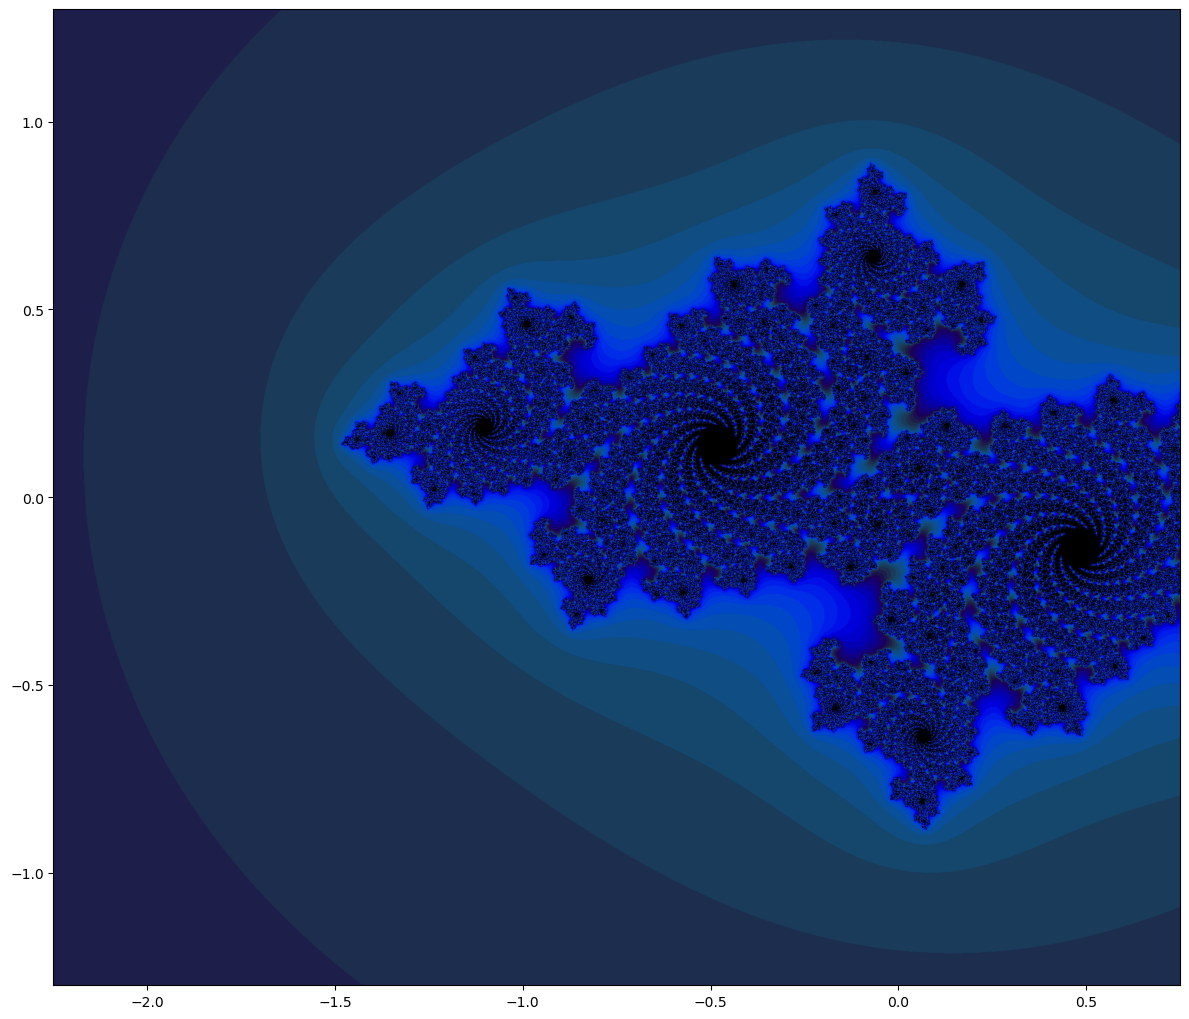

In [1]:
# Task 2.3 — Mandelbrot (PyTorch, GPU), with zoom + resolution controls
import torch
import numpy as np
import matplotlib.pyplot as plt

max_iter = 300                 # More iterations → more detail (slower)

# ---- RESOLUTION CONTROL ----
# - Think of step as the spacing between pixels in our photo.
# - Smaller step = pixels are closer together = sharper, more detailed picture.
# - Larger step = fewer pixels = faster to draw but blockier.
# - Example: step=0.005 might be a rough image; step=0.001 gives a high-resolution image.

step = 0.0015                  # Smaller step → higher resolution (slower). e.g., 0.001, 0.0008
# ----------------------------

# ---- ZOOM / PAN ----
# - These say how wide and tall the area of the "map" is that we take our photo of.
# - Big spans = zoomed out (see more of the map but less detail in small features).
# - Small spans = zoomed in (see fine details in a small area).
# - Zooming in without making step smaller will make the picture blurry or pixelated.

x_center, y_center = -0.75, 0  # Pan: choose the center
x_span = 3.0                   # Zoom: smaller span → zoom in (e.g., 0.5); larger → zoom out
y_span = 2.6                   # Keep aspect similar to your original [-1.3, 1.3]
# ----------------------------

# Flag for converting to Julia set
JULIA_SET = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Choose to run on GPU if available, otherwise CPU

# Work out the min and max coordinates for the chosen zoom and center
xmin, xmax = x_center - x_span/2, x_center + x_span/2
ymin, ymax = y_center - y_span/2, y_center + y_span/2

# Create a grid of coordinates (complex plane points) using NumPy
# Y and X store the coordinates of each pixel in the chosen region
Y, X = np.mgrid[ymin:ymax:step, xmin:xmax:step]

# Convert the coordinate grids into PyTorch tensors (for GPU/CPU computation)
x = torch.tensor(X, dtype=torch.float32) 
y = torch.tensor(Y, dtype=torch.float32)

# Combine x and y into complex numbers (x is real part, y is imaginary part)
z = torch.complex(x, y) # Together, X and Y form the grid, z, where each entry is a pixel’s coordinates in the complex plane.

# Keep a copy of z (zs will be updated each iteration)
zs = z.clone()

# Create an array to store how many iterations each point survives before diverging
ns = torch.zeros_like(x, dtype=torch.int32)

# Move all tensors to GPU or CPU
z = z.to(device)
zs = zs.to(device)
ns = ns.to(device)

# Fixed constant c for Julia set
c = torch.tensor(-0.7 + 0.27015j, dtype=torch.complex64, device=device)

# Mandelbrot iteration loop
for _ in range(max_iter):

    if JULIA_SET:
        # Use this equation for julia set
        zs = zs * zs + c
    else:
        # Apply Mandelbrot formula: z = z^2 + c
        # you run the Mandelbrot formula on all those points (in z) in parallel.
        zs = zs * zs + z
    
    # Check if the magnitude of z has gone beyond 2 (|z|^2 > 4 means it diverges)
    not_diverged = (zs.real*zs.real + zs.imag*zs.imag) < 16.0
    
    # Count how many iterations the point stayed bounded
    ns += not_diverged.int()

# Function to process the iteration counts into colors for plotting
def processFractal(a: np.ndarray):
    # Create a color cycling effect based on the number of iterations
    a_cyclic = (6.28 * a / 20.0).reshape(list(a.shape) + [1])
    img = np.concatenate([
        10 + 20 * np.cos(a_cyclic),   # Red channel
        30 + 50 * np.sin(a_cyclic),   # Green channel
        155 - 80 * np.cos(a_cyclic)   # Blue channel
    ], axis=2)
    
    # Make points inside the set black
    img[a == a.max()] = 0
    return np.uint8(np.clip(img, 0, 255))

# Create the plot
fig = plt.figure(figsize=(16, 10))
plt.imshow(
    processFractal(ns.detach().cpu().numpy()),  # Convert to NumPy for plotting
    extent=[xmin, xmax, ymin, ymax],            # Match the coordinate extents
    origin='lower'                              # Keep y-axis increasing upward
)
plt.tight_layout(pad=0)  # Remove white borders
plt.show()